In [1]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import nn


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
#подгрузка train и test (преобразуем картиночки сразу в тензора)
train_set = MNIST('.MNIST', transform=T.ToTensor(), train=True, download=True)
test_set = MNIST('.MNIST', transform=T.ToTensor(), train=False, download=True)


In [4]:
#len(train_set), len(test_set)
#out = train_set[5555]
#image, label = out
#image.shape, label - картинка и класс, которому она соотвествует

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        #конструктор базового класса
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
#Воспользуемся DataLoader чтобы формировать батчи
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
#Итерируемся по DataLoader ( мы типо шлепаем по бачам)
#Это просто как памятка
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
    

In [7]:
#Не забываем модельку кидать на device
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10
model = MLP(in_features=IMG_SIZE ** 2, num_classes=10, hidden_size=HIDDEN_SIZE).to(device)
#оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#функция потерь
criterion = nn.CrossEntropyLoss()


In [8]:
#подключим удобную библиотеку, которая позволяет делать прогресс бары,
#которые позволят нам следить за тем, как идет процесс обучения
from tqdm.notebook import tqdm
#from tqdm import tqdm
#Как работает ? Берете любой итерируемый объект, оборачиваете в tqdm.

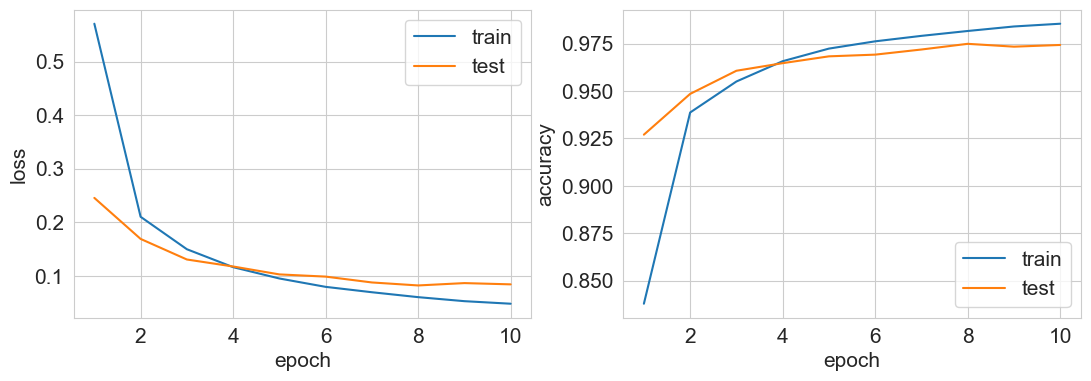

In [10]:
#Заведем массивчики, которые будут хранить историю метрик для графиков
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    #training loop - тренировочный цикл
    
    #Перед тем как делать эпоху обучения, переведем нашу можель в режим train
    model.train() # меняет поведение слоев
    
    #заведем переменные для подсчетам метрик
    train_loss, train_accuracy = 0.0, 0.0
    
    #обернем в tqdm чтобы отслеживать процесс обучения 
    for images, labels in tqdm(train_loader, desc='Training'):
        #Закидываем тензора на CUDA
        images = images.to(device)
        labels = labels.to(device)
        #зануление градиентов
        optimizer.zero_grad()
        #вытаскиваем логиты - предварительно схлопнув картиночки
        #логиты = batch_size x num_classes
        logits = model(torch.flatten(images, start_dim=1))
        loss = criterion(logits, labels) # тут loss - это усреднение по батчу
        loss.backward()
        optimizer.step()
        
        #будем прибавлять текущий лосс к суммарному: средний loss * кол-во картинок в батче
        train_loss += loss.item() * images.shape[0]# .item() - чтобы считались флоты питоновские
        #считаем кол-во правильных ответов
        # предсказание - это класс, которому нейронка предсказывает наибольшую вероятность. Для того чтобы посчитать этот класс
        # мы можем просто взять класс, которому соответствует наибольший логит ( т.к. softmax - монотонный )
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # argmax() возвращает индекс максимального значения вдоль указанной оси
        # (logits.argmax(dim=1) == labels).sum() - кол-во объектов, которые предсказались правильно
        
     #Когда мы сделали полный проход по обучающей выборке, то можем разделить loss и accuracy на число обектов
    train_loss /= len(train_loader.dataset) # Если бы написали len(train_loader) - нам бы вернулось кол-во батчей в 1-ой эпохе
    train_accuracy /= len(train_loader.dataset) # доля правильных ответов
    
    #скидываем в массивчики наши ошибки
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    
    
    #Цикл для теста (test loop)
    
    test_loss, test_accuracy = 0.0, 0.0
    
    #перевод в тестовый режим 
    model.eval() # говорит, что все слои которые есть будут применяться в режиме для теста
    
    for images, labels in tqdm(test_loader, desc='Validating'):
        #Закидываем тензора на CUDA
        images = images.to(device)
        labels = labels.to(device)
        
        #В тестовой выборке мы не будем ни на чем учиться !
        #Посколько нам тут не нужны градиенты, то чтобы все быстрее считалось,
        #пропишем контекстный менеджер
        
        with torch.no_grad(): # не дает вычислять градиенты
            logits = model(torch.flatten(images, start_dim=1))
            loss = criterion(logits, labels)
        
        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
               
    
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset) 
    
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    
    
    # После того, как мы провери одну эпоху обучения и одну эпоху валидации, то
    # нарисуем графички с помощью функции
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

*Кусок кода для построения графиков*
_____

*Чтобы мониторить состояние обучения мы будем рисовать графики.
Функция, которая ниже, будет брать два лосса на train и на test и две accuracy. Зачем? Так как у нас задача классификации - в качестве метрики качества у нас будет accuracy - доля правильных ответов*

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13,4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1 ), test_losses, label='test')
    axs[0].set_ylabel('loss')
                
    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')
                
    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
                
    plt.show()
            

*Для удобства определим как функцию кусок кода, где мы ходим по эпохам*

In [16]:
def train():
        #Заведем массивчики, которые будут хранить историю метрик для графиков
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        #training loop - тренировочный цикл

        #Перед тем как делать эпоху обучения, переведем нашу можель в режим train
        model.train() # меняет поведение слоев

        #заведем переменные для подсчетам метрик
        train_loss, train_accuracy = 0.0, 0.0

        #обернем в tqdm чтобы отслеживать процесс обучения 
        for images, labels in tqdm(train_loader, desc='Training'):
            #Закидываем тензора на CUDA
            images = images.to(device)
            labels = labels.to(device)
            #зануление градиентов
            optimizer.zero_grad()
            #вытаскиваем логиты - предварительно схлопнув картиночки
            #логиты = batch_size x num_classes
            logits = model(torch.flatten(images, start_dim=1))
            loss = criterion(logits, labels) # тут loss - это усреднение по батчу
            loss.backward()
            optimizer.step()

            #будем прибавлять текущий лосс к суммарному: средний loss * кол-во картинок в батче
            train_loss += loss.item() * images.shape[0]# .item() - чтобы считались флоты питоновские
            #считаем кол-во правильных ответов
            # предсказание - это класс, которому нейронка предсказывает наибольшую вероятность. Для того чтобы посчитать этот класс
            # мы можем просто взять класс, которому соответствует наибольший логит ( т.к. softmax - монотонный )
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
            # argmax() возвращает индекс максимального значения вдоль указанной оси
            # (logits.argmax(dim=1) == labels).sum() - кол-во объектов, которые предсказались правильно
        
        # после обучающей эпохи 
        if scheduler is not None:
            scheduler.step()
        
         #Когда мы сделали полный проход по обучающей выборке, то можем разделить loss и accuracy на число обектов
        train_loss /= len(train_loader.dataset) # Если бы написали len(train_loader) - нам бы вернулось кол-во батчей в 1-ой эпохе
        train_accuracy /= len(train_loader.dataset) # доля правильных ответов

        #скидываем в массивчики наши ошибки
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]


        #Цикл для теста (test loop)

        test_loss, test_accuracy = 0.0, 0.0

        #перевод в тестовый режим 
        model.eval() # говорит, что все слои которые есть будут применяться в режиме для теста

        for images, labels in tqdm(test_loader, desc='Validating'):
            #Закидываем тензора на CUDA
            images = images.to(device)
            labels = labels.to(device)

            #В тестовой выборке мы не будем ни на чем учиться !
            #Посколько нам тут не нужны градиенты, то чтобы все быстрее считалось,
            #пропишем контекстный менеджер

            with torch.no_grad(): # не дает вычислять градиенты
                logits = model(torch.flatten(images, start_dim=1))
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()


        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset) 

        test_losses += [test_loss]
        test_accuracies += [test_accuracy]


        # После того, как мы провери одну эпоху обучения и одну эпоху валидации, то
        # нарисуем графички с помощью функции
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

*Сейчас мы будем пробовать разные оптимизаторы с разными параметрами, чтобы посмотреть как они себя ведут*
_____


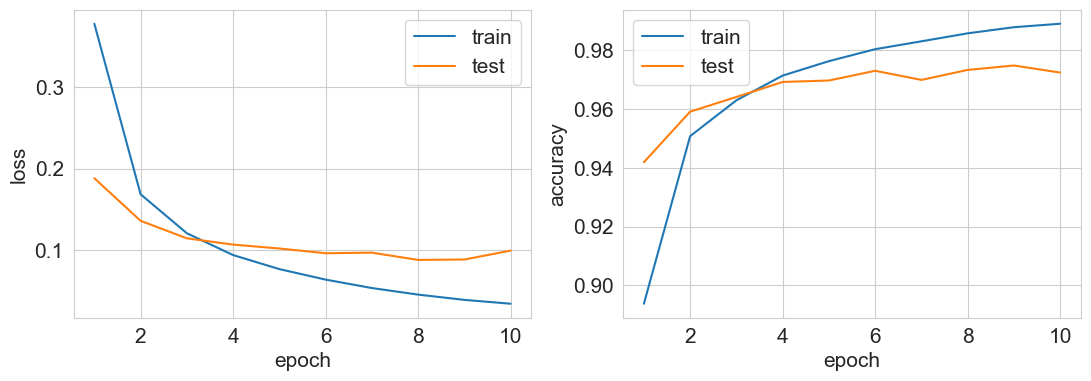

In [12]:

IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10
model = MLP(in_features=IMG_SIZE ** 2, num_classes=10, hidden_size=HIDDEN_SIZE).to(device)
#оптимизатор - на этот раз попробуем Адама
#для Адама нужно будет сделать lr шаг поменьше, моментум отсутствует 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#функция потерь
criterion = nn.CrossEntropyLoss()
scheduler = None
#Вызов функции, где у нас идет обучение и валидация + строятся графики
train()

Наблюдения
_____
Начиная с 4 эпози loss на train падает, а вот на teste более менее стабилизировался ( переобучение началось ). Но стоит заметить, что пока мы не включали ничего, что хоть как то могло влиять на регуляризацию ( т.е. нейронка учится как учится = > в любом случае будет переобучаться  ) 

Заметки: плохая идея ставить drop out на выход

*Попробуем Adam с добавлением weight decay*
____
weight decay - это типо как L2 регуляризация. ( для Adama weight decay и L2 - регуляризация это не совсем одно и тоже).

Под weight_decay мы подразумеваем то, что с каждым шагом веса схлопываются ( мы приближаем их к нулю ), а L2 - регуляризация - это просто добавление к loss компоненты с регуляризатором.

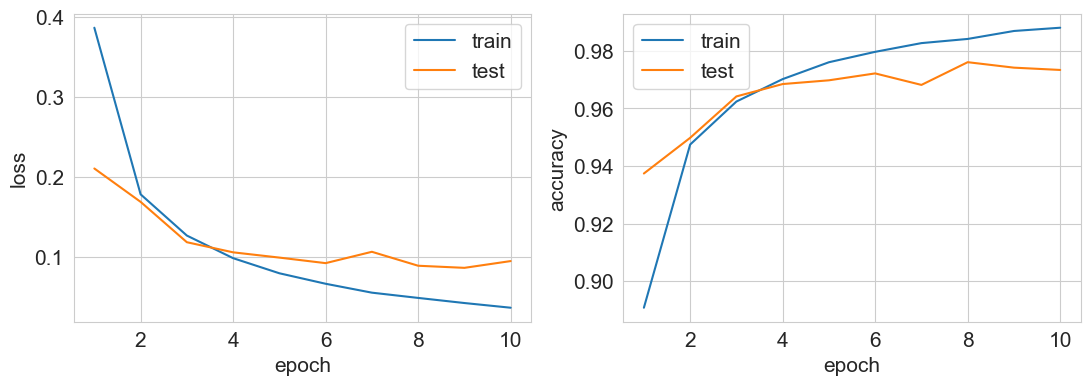

In [14]:
#weight_decay=1e-5

IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10
model = MLP(in_features=IMG_SIZE ** 2, num_classes=10, hidden_size=HIDDEN_SIZE).to(device)
#оптимизатор - на этот раз попробуем Адама
#Адам + weight_decay( для регуляризации / помогает от переобучения) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = None
#функция потерь
criterion = nn.CrossEntropyLoss()
#Вызов функции, где у нас идет обучение и валидация + строятся графики
train()

Заметки: Cходимость становится сильно медленнее ( к графику выше )

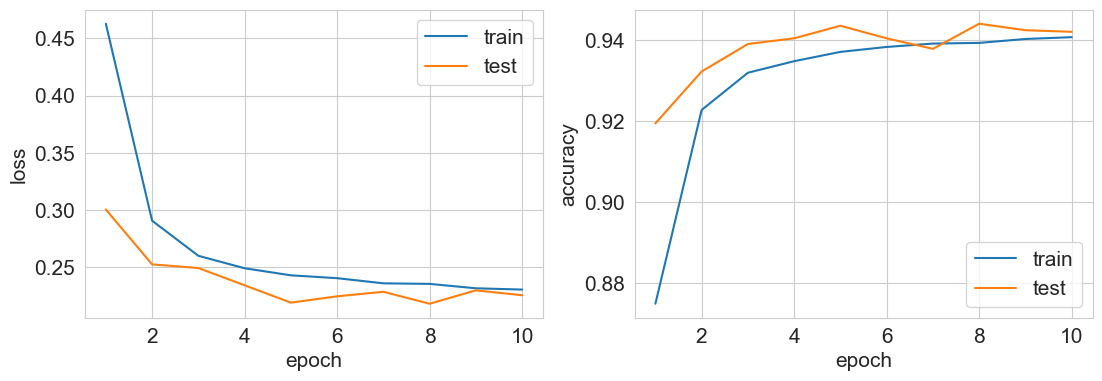

In [15]:
# делаем побольше weight_decay=1e-2

IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10
model = MLP(in_features=IMG_SIZE ** 2, num_classes=10, hidden_size=HIDDEN_SIZE).to(device)
#оптимизатор - на этот раз попробуем Адама
#Адам + weight_decay( для регуляризации / помогает от переобучения) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = None
#функция потерь
criterion = nn.CrossEntropyLoss()
#Вызов функции, где у нас идет обучение и валидация + строятся графики
train()

Заметки: видимо это слишком больше значение weight_decay=1e-2, так как loss на train опускается до больших значений и accuracy пострадало. 

Если хотим оптимальное, то нужно брать сетку и перебирать ( также как и с любыми другими гиперпараметрами ) !!!

*Мораль weight_decay - в принципе это тоже самое, что L2 регуляризация на веса, но не совсем*

!!! Если у вас какой - то сложный и непонятный loss энскейп, то тогда скорее всего имеет смысл использовать Adam.
Если вы делаете что - то новое ( с чем не очень хорошо знакомы ), то используйте Adam.


С другой сторны, если у вас какой - то известный датасет, на котором уже куча экспериментов, т.е. хорошо известны какие архитектуры с какими гиперпараметрами  на нём работают, то самый лучший вариант для вас получить ХОРОШЕЕ КАЧЕСТВО - это зайти на какой - нибудь ресурс типа *Paperswithcode* (вкладка datasets - > есть banchmarks ( какие статьи / как эксперементировали/ какое качество на нем получили ) 

Если эксперементируете с чем - то знакомым и заезженным, то вместо того, чтобы перебирать самим эти гиперпараметры и строить архитектуру, не тратьте свое время и нервы и зайдите куда - нибудь сюда.
________

Попробуем теперь сделать *расписание*

*Расписание* - это то как меняется наш learning_rate по ходу оптимизации. ( выгодно его потихонечку уменьшать ) 

Есть *torch.optim* - это подмодуль в котором лежат всякие штуки про оптимизацию ( SGD, Adam). Помимо этого есть ещё один подмодуль который называется *lr_scheduler*. 

Нужно сделать в Train loop изменения !

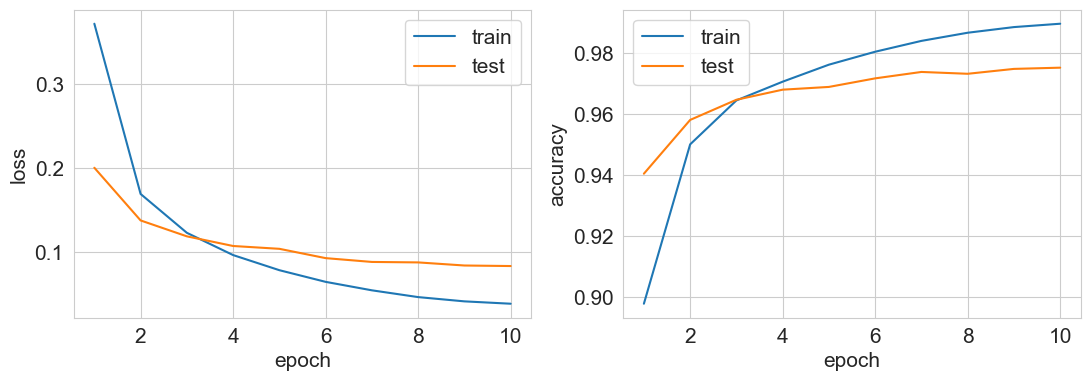

In [17]:

IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10
model = MLP(in_features=IMG_SIZE ** 2, num_classes=10, hidden_size=HIDDEN_SIZE).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Sheduler ( В парам T_MAX обычно пишут количество эпох)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()
train()

#По идее должно стать получше вместе с scheduler

Кам работает Dropout(p, inplace):
* p - вероятность того, что мы зануляем какие то входы 
* inplace - если поставить True, то работает быстрее


Это штука, которая направлена на то чтобы нам регулеризовать нейронку, потому что какую - то информацию выбивает и нейронке сложнее подгоняться.

In [19]:
x = torch.ones(5, 10)
x

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [22]:

dropout = nn.Dropout(p = 0.25, )#зануляем четверть выходов
#чтобы быть увереными, что мы в train Режиме
dropout.train()

Dropout(p=0.25, inplace=False)

In [23]:
dropout(x) 
# в итоге какие то координаты занулились
# в train режиме dropout - это умножение на маску и нормировка

tensor([[1.3333, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333,
         1.3333],
        [1.3333, 1.3333, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 0.0000,
         1.3333],
        [1.3333, 0.0000, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 0.0000, 0.0000,
         1.3333],
        [0.0000, 1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 1.3333, 0.0000, 1.3333,
         1.3333],
        [1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 0.0000, 1.3333, 0.0000, 1.3333,
         1.3333]])

In [24]:
#тоже самое в eval режиме
dropout.eval()
dropout(x)
# ничего не поменялось

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

Как работает batch_norm(num_features,eps, momentum, affin):

* num_features - (он без него не может)
* eps
* momentum - на сколько быстро у нас обновляются бегущие статистики 

Иногда эта штука тоже работает как регуляризатор, мы её добавляем и переобучение уменьшается ( непонятно почему )
(по факту мы впихиваем в середину сетки нормализацию)
Во всех современных архитектурах нормализация есть.

In [27]:
#Заведем batch норму. Они разные. Зависят от того, какой размерности у нас вход
# Если говорим про картинки, то вход четырехмерный - батч, каналы, 2 пространственные размерности
# Для этого применяем обычно torch.nn.BatchNorm2d

#Нам сейчас будет нужна 1d batch norma, так как у нас по сути одномерный вход - батч одномерных векторов
batch_norm = nn.BatchNorm1d(num_features=10, affine=False)
batch_norm.train()

BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [35]:
x =  1 + 2 * torch.randn(64, 10)
x.mean(dim=0), x.var(dim=0)

(tensor([0.7587, 0.8388, 0.7422, 0.7915, 0.9365, 1.0045, 1.0904, 1.1920, 1.0772,
         1.0230]),
 tensor([4.0136, 4.0247, 4.2315, 4.9264, 4.4852, 3.5634, 3.9662, 4.5712, 3.8002,
         3.3130]))

In [36]:
y = batch_norm(x)

In [37]:
y

tensor([[ 1.4801e+00, -7.9440e-01,  3.6884e-01,  7.5547e-01, -6.0908e-01,
          1.7825e+00, -5.9936e-01, -6.4734e-01, -6.0067e-01,  9.3066e-01],
        [ 5.2259e-02, -1.2590e-01,  5.2216e-01,  6.7363e-01, -1.1610e-01,
         -3.2417e-01, -5.6289e-01, -2.8476e-01, -5.5183e-01, -4.5061e-01],
        [-1.0702e+00, -6.6677e-01, -2.9245e-01, -1.0991e+00, -5.3220e-01,
          1.1389e+00,  1.3361e+00,  1.1036e+00,  1.5817e+00,  1.0188e+00],
        [ 1.1324e-01,  4.1008e-01,  1.4234e+00, -2.4064e+00, -6.9037e-01,
         -2.3465e-01,  1.0177e+00,  8.1642e-01,  4.4105e-01, -5.0175e-01],
        [ 1.6626e-01,  1.0772e+00, -1.2803e+00,  4.6503e-02,  3.9929e-02,
          3.2802e-01,  1.7753e-01,  5.6531e-01, -8.4266e-01,  9.7294e-02],
        [-1.8587e-01,  8.8010e-02,  8.0293e-01, -1.0780e+00, -7.9027e-02,
          5.3755e-01, -1.0892e-01, -4.9797e-01,  6.1265e-01, -8.9295e-01],
        [-2.7057e+00,  1.2339e-01, -5.6040e-01, -2.4330e-01,  3.7858e-01,
         -6.1264e-01, -3.1001e-0

In [38]:
#статистики по y
y.mean(dim=0), y.var(dim=0)

(tensor([ 6.1467e-08,  1.4901e-08, -2.2352e-08,  2.9802e-08, -2.0489e-08,
         -1.8626e-08,  0.0000e+00,  6.1467e-08,  5.3085e-08, -2.9802e-08],
        grad_fn=<MeanBackward1>),
 tensor([1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159,
         1.0159], grad_fn=<VarBackward0>))

In [40]:
batch_norm.running_mean

tensor([0.2234, 0.3168, 0.1111, 0.2526, 0.3450, 0.3621, 0.1914, 0.3688, 0.2907,
        0.3293])

In [41]:
batch_norm.running_var

tensor([1.8775, 1.2866, 1.4974, 1.7260, 1.2616, 1.3228, 1.7087, 1.6712, 1.4015,
        1.6723])